In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Data augmentation
# -----------------------------
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing(p=0.2)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Exemple avec CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# -----------------------------
# 2. Modèle
# -----------------------------
def get_model_improved(device='cpu'):
    model = nn.Sequential(
    # Bloc 1
    nn.Conv2d(3, 32, kernel_size=4, padding=1, bias=True),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32, 32, kernel_size=4, padding=1, bias=True),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.2),

    # Bloc 2
    nn.Conv2d(32, 64, kernel_size=4, padding=1, bias=True),
    nn.ReLU(),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 64, kernel_size=4, padding=1, bias=True),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.3),

    # Bloc 3
    nn.Conv2d(64, 128, kernel_size=4, padding=1, bias=True),
    nn.ReLU(),
    nn.BatchNorm2d(128),

    nn.Conv2d(128, 128, kernel_size=1, padding=0, bias=True),  # bottleneck
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.AdaptiveAvgPool2d((1,1)),

    nn.Flatten(),

    # Classifier compact
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 10)
    ).to(device)



    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    return model, loss_fn, optimizer, scheduler


# -----------------------------
# 3. Entraînement + Early stopping + Tracking
# -----------------------------
def train_model(model, loss_fn, optimizer, scheduler, train_loader, val_loader, device='cpu', epochs=30, patience=5):
    best_val_loss = np.inf
    patience_counter = 0

    # Historique pour les courbes
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / total

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = loss_fn(outputs, y)
                val_loss += loss.item() * X.size(0)
                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        val_acc = 100 * correct / total
        val_loss /= total

        scheduler.step(val_loss)

        # Enregistrement
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | "
              f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.2f}%")

        # Early stopping
        if val_loss > best_val_loss - 1e-3:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
        else:
            patience_counter = 0
            best_val_loss = val_loss

    # -----------------------------
    # 4. Affichage des courbes
    # -----------------------------
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss évolution')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy ')
    plt.title('Accuracy évolution')
    plt.legend()

    plt.tight_layout()
    plt.show()


# -----------------------------
# 5. Lancement
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, loss_fn, optimizer, scheduler = get_model_improved(device)
train_model(model, loss_fn, optimizer, scheduler, train_loader, val_loader, device)

In [ ]:
torch.save(model.state_dict(), "model_weights.pth")
files.download("model_weights.pth")

**INTERPOLATION DU FILTRE**

In [ ]:
from scipy.interpolate import RegularGridInterpolator

def interpolate_filter(filter_weights, smooth_factor=50):
    """Interpolation cubique bilinéaire pour passer du filtre discret à une fonction continue"""
    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h-1, smooth_factor)
    xnew = np.linspace(0, w-1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    return Zsmooth

**Projection dans schwartz**

In [ ]:
def project_to_schwartz(Zsmooth, sigma=None):
    """Projette un filtre interpolé dans un espace proche de S(R^2) via une fenêtre gaussienne"""
    H, W = Zsmooth.shape
    if sigma is None:
        sigma = min(H, W) / 2
    y = np.arange(H) - H/2
    x = np.arange(W) - W/2
    X, Y = np.meshgrid(x, y)
    gauss_window = np.exp(-(X**2 + Y**2) / (2*sigma**2))
    Z_schwartz = Zsmooth * gauss_window
    return Z_schwartz

**Mesure de régularité**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian_window(shape, sigma=1.0, center=None):
    """Fenêtre gaussienne normalisée 2D"""
    n, m = shape
    if center is None:
        center = (n//2, m//2)
    y = np.arange(n) - center[0]
    x = np.arange(m) - center[1]
    X, Y = np.meshgrid(x, y)
    g = np.exp(-(X**2 + Y**2)/(2*sigma**2))
    g /= np.sqrt(np.sum(g**2))
    return g

def local_sobolev_gauss_3D(h, block_size=(5,5), alpha=2, sigma=1.0):
    """
    Calcule la régularité locale de sous-blocs d'un filtre 2D
    avec fenêtre gaussienne et pondération Sobolev.

    Retour :
    - reg_map : matrice de régularité locale
    """
    n, m = h.shape
    bh, bw = block_size
    reg_map = np.zeros((n - bh + 1, m - bw + 1))

    for i in range(n - bh + 1):
        for j in range(m - bw + 1):
            block = h[i:i+bh, j:j+bw]
            g = gaussian_window(block.shape, sigma=sigma)
            block_win = block * g

            H = np.fft.fft2(block_win)
            H = np.fft.fftshift(H)

            u = np.fft.fftshift(np.fft.fftfreq(bh))
            v = np.fft.fftshift(np.fft.fftfreq(bw))
            U, V = np.meshgrid(u, v, indexing='ij')

            freq_weight = (1 + U**2 + V**2)**alpha
            reg_map[i,j] = np.sum(freq_weight * np.abs(H)**2)

    return reg_map


**Récupération des poids réguliers**

In [ ]:
def graphcut_filter_surface(Zsmooth, percentile):
    """
    Conserve uniquement les valeurs les plus petites (en valeur absolue)
    selon un seuil basé sur le percentile.
    #
    Zsmooth : surface lissée (2D numpy array)
    percentile : pourcentage de valeurs à conserver (les plus petites)
    """
    threshold = np.percentile(np.abs(Zsmooth), percentile)
    mask = np.abs(Zsmooth) <= threshold  # True là où on garde
    Zcut = np.where(mask, Zsmooth, np.nan)  # NaN pour visualiser les trous
    return Zcut, mask


Mesure de valeur

In [ ]:
def magnitude_mesure(Zcut):
    """
    Calcule la somme des valeurs absolues de Zcut.
    Les NaN sont traités comme des zéros.
    """
    return np.nansum(np.abs(Zcut))

In [ ]:
from scipy import ndimage
def ultimate_graphcut_filter_analysis_reg(filter_weights):
  """
  Calcule la régularité totale d'un filtre
  #
  filter_weights : poids d'un filtre donné
  """
  Zsmooth = interpolate_filter(filter_weights)
  Z_schwartz = project_to_schwartz(Zsmooth)
  reg_map = local_sobolev_gauss_3D(Zsmooth, block_size=(5,5), alpha=2, sigma=58)
  Zcut, mask = graphcut_filter_surface(reg_map, percentile=80) #Pourcentage à modifier 
  return magnitude_mesure(Zcut)

**Classement des filtres**

In [ ]:
from scipy.interpolate import RegularGridInterpolator
import torch

conv_layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]

filter_ranking = {}
conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]

for m_idx, conv_layer in enumerate(conv_layers):
    print(f"   Couche {m_idx+1}/{len(conv_layers)}...")

    # Vérification si la couche est un bottleneck
    # Si la couche est un bottleneck, on la saute
    # Le bottleneck est une convolution 1x1 après une couche de plus grande taille, on suppose que c'est un critère ici
    if conv_layer.kernel_size == (1, 1):
        print(f"   Couche {m_idx+1} est un bottleneck, on passe.")
        continue

    filter_ranking[m_idx] = {}

    out_channels, in_channels, h, w = conv_layer.weight.shape

    for oc in range(out_channels):
        print(oc)
        filter_ranking[m_idx][oc] = {}
        for ic in range(in_channels):
            print(ic)

            # 1. Récupère les poids du filtre
            filter_weights = conv_layer.weight[oc, ic].detach().cpu().numpy()

            #2. Calcule la régularité du filtre
            base_importance = ultimate_graphcut_filter_analysis_reg(filter_weights)

            # 3. Peuple le dictionnaire à l'indice de la couche et du filtre correspondant, la valeur étant la mesure de régularité
            filter_ranking[m_idx][oc][ic] = float(base_importance)




   Couche 1/6...
0
0
1
2
1
0
1
2
2
0
1
2
3
0
1
2
4
0
1
2
5
0
1
2
6
0
1
2
7
0
1
2
8
0
1
2
9
0
1
2
10
0
1
2
11
0
1
2
12
0
1
2
13
0
1
2
14
0
1
2
15
0
1
2
16
0
1
2
17
0
1
2
18
0
1
2
19
0
1
2
20
0
1
2
21
0
1
2
22
0
1
2
23
0
1
2
24
0
1
2
25
0
1
2
26
0
1
2
27
0
1
2
28
0
1
2
29
0
1
2
30
0
1
2
31
0
1
2
   Couche 2/6...
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26

In [ ]:
with open("filter_ranking.json", "w") as f: 
    json.dump(filter_ranking, f, indent=4)
from google.colab import files
files.download("filter_ranking.json")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_filter_ranking_combined(filter_ranking):
    """
    Affiche tous les filtres de toutes les couches dans un seul graphe,
    avec une ligne rouge séparant les couches.

    Args:
        filter_ranking : dict[layer_idx][out_ch][in_ch] = score
    """
    all_scores = []
    layer_boundaries = []
    current_idx = 0

    # Parcourir les couches
    for l_idx in sorted(filter_ranking.keys()):
        layer_dict = filter_ranking[l_idx]
        # Moyenne sur les canaux d'entrée pour chaque filtre de sortie
        out_scores = [np.mean(list(layer_dict[oc].values())) for oc in sorted(layer_dict.keys())]
        all_scores.extend(out_scores)
        current_idx += len(out_scores)
        layer_boundaries.append(current_idx)  # position pour la ligne rouge

    # Plot
    plt.figure(figsize=(12,5))
    plt.bar(range(len(all_scores)), all_scores)
    plt.xlabel("Filtres (toutes couches concaténées)")
    plt.ylabel("Score d'importance moyen")
    plt.title("Importance des filtres par couche")

    # Tracer les lignes rouges pour séparer les couches
    for b in layer_boundaries[:-1]:  # pas besoin de la dernière
        plt.axvline(x=b-0.5, color='red', linestyle='--', linewidth=1)

    plt.show()


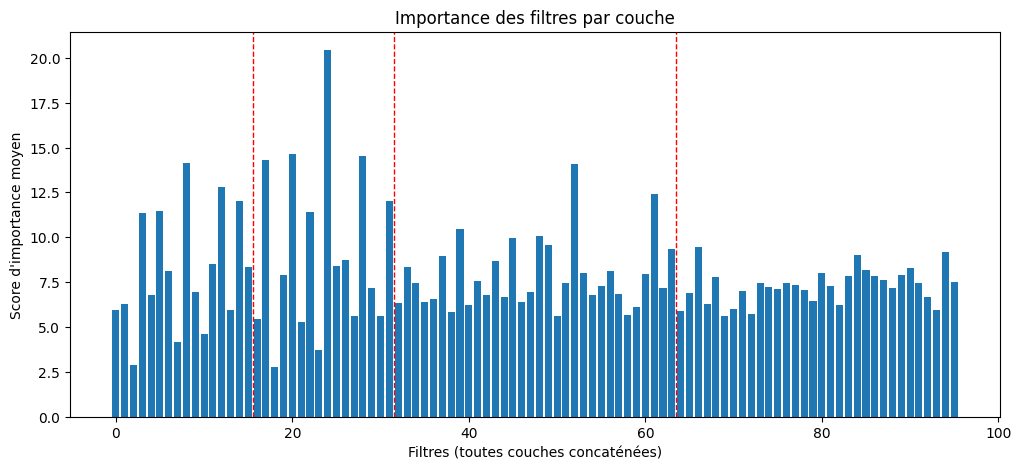

In [ ]:
plot_filter_ranking_combined(filter_ranking)

**Récupération des données enregistrés**

In [ ]:
#Récupération des poids du modèle
from google.colab import files
uploaded = files.upload()  # récupérer le fichier de poids .pth
model.load_state_dict(torch.load('model_weights.pth', map_location='cpu'))

In [ ]:
#Récupération du dictionnaire
import json
uploaded = files.upload()  # récupérer le fichier de poids .pth
with open("dictionnaire.json", "w") as f:
    json.dump(filter_ranking, f, indent=4)
from google.colab import files
files.download("dictionnaire.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Pruning du modèle*

In [ ]:
import torch
import torch.nn as nn
import copy
from collections import defaultdict
import numpy as np

def prune_model_by_filters_removal(model, top_indices_list, input_size=(3, 32, 32)):
    """
    VERSION CORRIGÉE: Supprime réellement les filtres pour réduire les paramètres.

    Args:
        model: modèle PyTorch nn.Sequential
        top_indices_list: [(layer_idx, out_ch, in_ch), ...] - filtres à CONSERVER
        input_size: taille d'entrée (channels, height, width)

    Returns:
        Modèle pruné avec moins de paramètres
    """
    device = next(model.parameters()).device
    model_copy = copy.deepcopy(model)

    # Organiser les filtres à conserver par couche
    filters_to_keep = defaultdict(set)
    for layer_idx, out_ch, in_ch in top_indices_list:
        filters_to_keep[layer_idx].add(out_ch)

    # Convertir en listes triées
    for layer_idx in filters_to_keep:
        filters_to_keep[layer_idx] = sorted(list(filters_to_keep[layer_idx]))

    new_layers = []
    conv_layers = [i for i, layer in enumerate(model_copy) if isinstance(layer, nn.Conv2d)]
    prev_kept_channels = None

    for i, layer in enumerate(model_copy):
        if isinstance(layer, nn.Conv2d):
            # Trouver l'index de cette couche conv
            conv_idx = conv_layers.index(i)

            # Déterminer les canaux de sortie à conserver
            if conv_idx in filters_to_keep:
                keep_out_channels = filters_to_keep[conv_idx]
            else:
                # Si pas spécifié, garder tous les canaux
                keep_out_channels = list(range(layer.out_channels))

            # Déterminer les canaux d'entrée
            if conv_idx == 0:
                # Première couche: garder tous les canaux d'entrée (RGB)
                new_in_channels = layer.in_channels
                keep_in_channels = list(range(layer.in_channels))
            else:
                # Couches suivantes: s'adapter aux canaux conservés de la couche précédente
                new_in_channels = len(prev_kept_channels) if prev_kept_channels else layer.in_channels
                keep_in_channels = prev_kept_channels if prev_kept_channels else list(range(layer.in_channels))

            new_out_channels = len(keep_out_channels)

            # Créer la nouvelle couche Conv2d RÉDUITE
            new_conv = nn.Conv2d(
                in_channels=new_in_channels,
                out_channels=new_out_channels,
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
                bias=(layer.bias is not None)
            ).to(device)

            # Copier uniquement les poids des filtres conservés
            with torch.no_grad():
                for new_out_idx, old_out_idx in enumerate(keep_out_channels):
                    for new_in_idx, old_in_idx in enumerate(keep_in_channels):
                        new_conv.weight[new_out_idx, new_in_idx] = layer.weight[old_out_idx, old_in_idx]

                    if layer.bias is not None:
                        new_conv.bias[new_out_idx] = layer.bias[old_out_idx]

            new_layers.append(new_conv)
            prev_kept_channels = keep_out_channels

        elif isinstance(layer, nn.BatchNorm2d):
            # Adapter BatchNorm aux canaux conservés
            if prev_kept_channels is not None:
                new_bn = nn.BatchNorm2d(len(prev_kept_channels)).to(device)
                with torch.no_grad():
                    for new_idx, old_idx in enumerate(prev_kept_channels):
                        new_bn.weight[new_idx] = layer.weight[old_idx]
                        new_bn.bias[new_idx] = layer.bias[old_idx]
                        new_bn.running_mean[new_idx] = layer.running_mean[old_idx]
                        new_bn.running_var[new_idx] = layer.running_var[old_idx]
                new_layers.append(new_bn)
            else:
                new_layers.append(copy.deepcopy(layer))

        elif isinstance(layer, nn.Linear):
            # Ajuster la première couche Linear après Flatten
            if len([l for l in new_layers if isinstance(l, nn.Linear)]) == 0:
                # Calculer la nouvelle taille après les couches conv
                new_input_features = calculate_linear_input_size(new_layers, input_size)

                new_linear = nn.Linear(
                    in_features=new_input_features,
                    out_features=layer.out_features,
                    bias=(layer.bias is not None)
                ).to(device)

                # Copier les poids (avec adaptation de taille)
                with torch.no_grad():
                    min_features = min(new_input_features, layer.in_features)
                    new_linear.weight[:, :min_features] = layer.weight[:, :min_features]
                    if layer.bias is not None:
                        new_linear.bias[:] = layer.bias[:]

                new_layers.append(new_linear)
            else:
                # Autres couches Linear: copier tel quel
                new_layers.append(copy.deepcopy(layer))
        else:
            # Autres couches (ReLU, MaxPool, Dropout, Flatten)
            new_layers.append(copy.deepcopy(layer))

    return nn.Sequential(*new_layers).to(device)

def calculate_linear_input_size(conv_layers, input_size):
    """
    Calcule la taille d'entrée pour la première couche Linear
    en simulant une passe avant à travers les couches conv.
    """
    channels, h, w = input_size

    for layer in conv_layers:
        if isinstance(layer, nn.Conv2d):
            # Calculer nouvelle taille après convolution
            kernel_size = layer.kernel_size[0] if isinstance(layer.kernel_size, tuple) else layer.kernel_size
            stride = layer.stride[0] if isinstance(layer.stride, tuple) else layer.stride
            padding = layer.padding[0] if isinstance(layer.padding, tuple) else layer.padding

            h = (h + 2*padding - kernel_size) // stride + 1
            w = (w + 2*padding - kernel_size) // stride + 1
            channels = layer.out_channels

        elif isinstance(layer, nn.MaxPool2d):
            kernel_size = layer.kernel_size
            stride = layer.stride if layer.stride else kernel_size
            h = h // stride
            w = w // stride

    return channels * h * w

def structured_channel_pruning(model, importance_dict, keep_ratio=0.5):
    """
    Pruning structuré: supprime des canaux entiers basé sur leur importance moyenne.
    Plus efficace pour réduire réellement les paramètres.

    Args:
        model: modèle à pruner
        importance_dict: dict[layer][out_ch][in_ch] = importance
        keep_ratio: fraction de canaux à conserver (0.5 = 50%)
    """
    # Calculer l'importance moyenne par canal de sortie
    channel_importance = {}

    for layer_idx in importance_dict:
        channel_importance[layer_idx] = {}
        for out_ch in importance_dict[layer_idx]:
            # Moyenne d'importance sur tous les canaux d'entrée pour ce canal de sortie
            avg_importance = np.mean(list(importance_dict[layer_idx][out_ch].values()))
            channel_importance[layer_idx][out_ch] = avg_importance

    # Sélectionner les top canaux pour chaque couche
    top_indices = []
    for layer_idx in channel_importance:
        # Trier par importance décroissante
        channels_by_importance = sorted(
            channel_importance[layer_idx].items(),
            key=lambda x: x[1],
            reverse=False
        )

        # Garder le top keep_ratio
        n_keep = max(1, int(len(channels_by_importance) * keep_ratio))
        top_channels = [ch for ch, _ in channels_by_importance[:n_keep]]

        # Créer les indices pour tous les canaux d'entrée de ces canaux de sortie
        for out_ch in top_channels:
            for in_ch in importance_dict[layer_idx][out_ch]:
                top_indices.append((layer_idx, out_ch, in_ch))

    return top_indices

def test_effective_pruning(model, importance_dict, trn_dl, val_dl, loss_fn, keep_ratios=[0.8]):
    """
    Test de pruning avec réduction EFFECTIVE des paramètres.
    """
    print("Test de Pruning avec Réduction Effective des Paramètres")
    print("="*60)

    # Baseline
    orig_params = sum(p.numel() for p in model.parameters())
    orig_loss, orig_acc = evaluate_model(model, val_dl, loss_fn)

    print(f"Modèle original: {orig_acc:.4f} accuracy, {orig_params:,} paramètres")
    print()

    results = []

    for keep_ratio in keep_ratios:
        print(f"Test avec keep_ratio = {keep_ratio} ({keep_ratio*100:.0f}% des canaux)")
        print("-" * 40)

        try:
            # Pruning structuré par canaux
            top_indices = structured_channel_pruning(model, importance_dict, keep_ratio)
            print(f"Filtres sélectionnés: {len(top_indices)}")

            # Appliquer le pruning EFFECTIF
            pruned_model = prune_model_by_filters_removal(model, top_indices, input_size=(3, 32, 32))

            # Vérifier la réduction
            pruned_params = sum(p.numel() for p in pruned_model.parameters())
            actual_reduction = (orig_params - pruned_params) / orig_params * 100

            print(f"Paramètres avant: {orig_params:,}")
            print(f"Paramètres après: {pruned_params:,}")
            print(f"Réduction RÉELLE: {actual_reduction:.1f}%")

            # Test du modèle pruné
            val_loss_before, val_acc_before = evaluate_model(pruned_model, val_dl, loss_fn)
            print(f"Accuracy avant fine-tuning: {val_acc_before:.4f}")

            # Fine-tuning
            print("Fine-tuning...")
            pruned_model = fine_tune_pruned_model(pruned_model, trn_dl, val_dl, loss_fn, epochs=5, lr=1e-3)

            val_loss_final, val_acc_final = evaluate_model(pruned_model, val_dl, loss_fn)

            accuracy_retention = (val_acc_final / orig_acc) * 100
            compression_ratio = orig_params / pruned_params

            print(f"Accuracy finale: {val_acc_final:.4f}")
            print(f"Rétention accuracy: {accuracy_retention:.1f}%")
            print(f"Ratio de compression: {compression_ratio:.1f}x")
            print()

            results.append({
                'keep_ratio': keep_ratio,
                'actual_reduction': actual_reduction,
                'final_accuracy': val_acc_final,
                'accuracy_retention': accuracy_retention,
                'compression_ratio': compression_ratio,
                'pruned_params': pruned_params
            })

        except Exception as e:
            print(f"Erreur avec keep_ratio {keep_ratio}: {e}")
            print()

    # Résumé des résultats
    print("RÉSUMÉ DES RÉSULTATS")
    print("="*40)
    for r in results:
        print(f"Keep {r['keep_ratio']*100:.0f}%: {r['actual_reduction']:.1f}% réduction, "
              f"{r['accuracy_retention']:.1f}% accuracy, {r['compression_ratio']:.1f}x compression")

    return pruned_model

# Fonction d'évaluation (si pas déjà définie)
def evaluate_model(model, val_dl, loss_fn):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in val_dl:
            device = next(model.parameters()).device
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss += loss_fn(pred, y).item() * x.size(0)
            total_correct += (pred.argmax(1) == y).sum().item()
            total_samples += x.size(0)

    return total_loss / total_samples, total_correct / total_samples

def fine_tune_pruned_model(pruned_model, trn_dl, val_dl, loss_fn, epochs=10, lr=1e-4):
    """Fine-tune le modèle pruné pour récupérer l'accuracy."""
    from torch.optim import Adam

    device = next(pruned_model.parameters()).device
    optimizer = Adam(pruned_model.parameters(), lr=lr)

    for epoch in range(epochs):
        pruned_model.train()
        for x, y in trn_dl:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = pruned_model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

        # Validation check
        val_loss, val_acc = evaluate_model(pruned_model, val_dl, loss_fn)
        if epoch == 0 or (epoch + 1) % 2 == 0:
            print(f"  Epoch {epoch+1}: Val Acc = {val_acc:.4f}")

    return pruned_model


In [ ]:
import copy
model_test = copy.deepcopy(model)
pruned_model = test_effective_pruning(model_test,filter_ranking,train_loader, val_loader, loss_fn) 

Test de Pruning avec Réduction Effective des Paramètres
Modèle original: 0.8405 accuracy, 282,826 paramètres

Test avec keep_ratio = 0.8 (80% des canaux)
----------------------------------------
Filtres sélectionnés: 12299
Paramètres avant: 282,826
Paramètres après: 676,042
Réduction RÉELLE: -139.0%
Erreur avec keep_ratio 0.8: mat1 and mat2 shapes cannot be multiplied (128x128 and 3200x128)

RÉSUMÉ DES RÉSULTATS
